In [2]:
##########################################################################

# I acknowledge the use of ChatGPT and AI Tools in Helping me Code and Debug the work in this File

##########################################################################

In [ ]:
import numpy as np
import pandas as pd 
import re
import matplotlib.pyplot as plt



# file_path = "/scratch/network/mm4846/transcripts_2006_2025_03_18_enhanced.csv"
# df = pd.read_csv(file_path)
# df


file_path = "/scratch/network/mm4846/transcripts_2006_2025_03_18_final_master.csv"

# Load whole CSV (yes, all 30k rows), then sample
df = pd.read_csv(file_path).sample(n=20, random_state=44)



In [6]:
print(df['ticker'][5948])
print(df['presentation'][5948])


HSIC
Glen J. Santangelo - Crédit Suisse AG, Research Division Robert P. Jones - Goldman Sachs Group Inc., Research Division Roberto Fatta S. Brandon Couillard - Jefferies & Company, Inc., Research Division Lawrence C. Marsh - Barclays Capital, Research Division Jeffrey D. Johnson - Robert W. Baird & Co. Incorporated, Research Division Good morning, ladies and gentlemen, and welcome to the Henry Schein Second Quarter Conference Call. [Operator Instructions] As a reminder, this call is being recorded. I would now like to introduce your host for today's call, Susan Vassallo, Henry Schein's Vice President of Corporate Communications. Please go ahead, Susan. Thank you, operator, and my thanks to each of you for joining us to discuss Henry Schein's second quarter results. With me this morning are Stanley Bergman, Chairman and Chief Executive Officer of Henry Schein; and Steven Paladino, Executive Vice President and Chief Financial Officer. Before we begin, I would like to state that certain 

In [3]:
# df

In [2]:
import ast
import re
import pandas as pd
import numpy as np
import swifter  # For automatic parallelization

def count_mentions(text, compiled_patterns):
    """Counts occurrences of compiled regex patterns in text."""
    if not isinstance(text, str):
        return 0
    text_lower = text.lower()
    return sum(len(pattern.findall(text_lower)) for pattern in compiled_patterns)

def count_qa_mentions(qna_pairs, compiled_patterns):
    """Return total mentions in questions and answers."""
    if not isinstance(qna_pairs, list):
        return 0, 0  # Avoid unnecessary looping

    question_mentions = sum(
        count_mentions(pair.get("question", ""), compiled_patterns) for pair in qna_pairs if isinstance(pair, dict)
    )
    answer_mentions = sum(
        count_mentions(pair.get("answer", ""), compiled_patterns) for pair in qna_pairs if isinstance(pair, dict)
    )

    return question_mentions, answer_mentions

def count_qa_mentions_pairs(qna_pairs, compiled_patterns):
    """Return (#pairs_with_mention_in_question, #pairs_with_mention_in_answer)."""
    if not isinstance(qna_pairs, list):
        return 0, 0  # Avoid unnecessary looping

    question_pairs_count = sum(
        count_mentions(pair.get("question", ""), compiled_patterns) > 0 for pair in qna_pairs if isinstance(pair, dict)
    )
    answer_pairs_count = sum(
        count_mentions(pair.get("answer", ""), compiled_patterns) > 0 for pair in qna_pairs if isinstance(pair, dict)
    )

    return question_pairs_count, answer_pairs_count

def compile_patterns(word_list):
    """Precompiles regex patterns for efficiency."""
    return [re.compile(r'\b' + re.escape(term.lower()) + r'\b') for term in word_list]

def add_topic_mention_columns(df, prefix, compiled_patterns):
    """
    Adds mention count columns to the DataFrame.
    Optimized with precompiled regex patterns & vectorized operations.
    """
    # Convert column to NumPy array for fast iteration
    qa_pairs_values = df["question_answer_pairs_parsed"].values
    presentation_values = df["presentation"].values

    # Apply functions using swifter (parallelized processing)
    qa_counts = np.stack(df["question_answer_pairs_parsed"].swifter.apply(lambda pairs: count_qa_mentions_pairs(pairs, compiled_patterns)).to_numpy())
    presentation_counts = np.array(df["presentation"].swifter.apply(lambda text: count_mentions(text, compiled_patterns)))

    # Assign to DataFrame in a single step (efficient)
    df[f"{prefix}_mentions_qna_question_count"] = qa_counts[:, 0]
    # df[f"{prefix}_mentions_qna_answer_count"] = qa_counts[:, 1]
    df[f"{prefix}_mentions_presentation"] = presentation_counts

    return df

def parse_stringified_list(df, column_name="question_answer_pairs"):
    """Ensures column contains a list of dictionaries. Parses only if the row is a string."""
    def safe_eval(val):
        if isinstance(val, list):  # Already parsed
            return val
        try:
            return ast.literal_eval(val) if isinstance(val, str) else []
        except (ValueError, SyntaxError):
            return []  # Return empty if parsing fails
    
    parsed_column = "negative_questions_parsed" if column_name == "negative_questions" else "question_answer_pairs_parsed"
    
    # Use parallelized `.swifter.apply()` for fast processing
    df[parsed_column] = df[column_name].swifter.apply(safe_eval)

    return df

def process_topic_mentions(df, word_lists_with_prefixes):
    """
    Processes multiple word lists systematically.
    Optimized with precompiled regex and parallelized operations.
    """
    compiled_patterns_dict = {prefix: compile_patterns(word_list) for prefix, word_list in word_lists_with_prefixes.items()}

    for prefix, compiled_patterns in compiled_patterns_dict.items():
        df = add_topic_mention_columns(df, prefix, compiled_patterns)

    return df


/home/mm4846/.conda/envs/myenv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
import ast
import re
import pandas as pd
import numpy as np
import swifter  # For automatic parallelization

# Compile regex patterns for efficiency
compiled_other_terms = [re.compile(r'\b' + re.escape(term.lower()) + r'\b') for term in other_terms]

def count_mentions(text, compiled_patterns):
    """Checks if any compiled regex pattern appears in text."""
    if not isinstance(text, str):
        return False
    text_lower = text.lower()
    return any(pattern.search(text_lower) for pattern in compiled_patterns)

def count_long_questions_without_terms(df):
    """Counts questions with over 10 words that do NOT include any terms from `other_terms`."""
    def filter_questions(qna_pairs):
        if not isinstance(qna_pairs, list):
            return 0  # Avoid unnecessary looping

        count = 0
        for pair in qna_pairs:
            if isinstance(pair, dict):
                question = pair.get("question", "")
                if isinstance(question, str):
                    word_count = len(question.split())
                    contains_other_term = count_mentions(question, compiled_other_terms)
                    
                    if word_count > 10 and not contains_other_term:
                        count += 1
        return count

    # Apply function to dataframe using swifter for parallel processing
    df["other_qna_question_count"] = df["question_answer_pairs_parsed"].swifter.progress_bar(False).apply(filter_questions)

    return df


In [7]:
def get_other_questions(qna_pairs):
    """Returns list of 'other' questions: >10 words and don't contain any `other_terms`."""
    if not isinstance(qna_pairs, list):
        return []

    result = []
    for pair in qna_pairs:
        if isinstance(pair, dict):
            question = pair.get("question", "")
            if isinstance(question, str):
                word_count = len(question.split())
                contains_other_term = count_mentions(question, compiled_other_terms)

                if word_count > 10 and not contains_other_term:
                    result.append(question)
    return result


def add_other_questions_column(df):
    """
    Adds a column with 'other' questions (as a list), and a count column.
    Uses swifter for parallel processing.
    """
    df["other_qna_questions"] = df["question_answer_pairs_parsed"].swifter.progress_bar(False).apply(get_other_questions)
    df["other_qna_question_count"] = df["other_qna_questions"].apply(len)
    return df

In [11]:


# df['question_answer_pairs'] = df['qna_pairs'].copy()
# df = df.drop(columns = ['qna_pairs'])
# df = parse_stringified_list(df)
# df = df[df["year"] >= 2010]

chunk_size = 5000  # Tune this if needed
df_list = [df.iloc[i:i + chunk_size] for i in range(0, len(df), chunk_size)]

df_processed = [add_other_questions_column(chunk) for chunk in df_list]
df = pd.concat(df_processed)



/tmp/ipykernel_2307412/764241042.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["other_qna_questions"] = df["question_answer_pairs_parsed"].swifter.progress_bar(False).apply(get_other_questions)
/tmp/ipykernel_2307412/764241042.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["other_qna_question_count"] = df["other_qna_questions"].apply(len)


In [19]:
rows = []
question_id = 1

for i, question_list in enumerate(df['other_qna_questions']):
    for q in question_list:
        rows.append({
            "question_id": question_id,
            "row_index": i,
            "question": q,
            "llm_topic": "other",
            "true_topic": ""  # you will label this
        })
        question_id += 1

# Create DataFrame
questions_df = pd.DataFrame(rows)

# Random sample of 200 (or less if fewer are available)
sampled_df = questions_df.sample(n=min(200, len(questions_df)), random_state=42).sort_values("question_id")

# Save to Excel
sampled_df.to_excel("other_qna_questions_for_labeling.xlsx", index=False)

In [29]:
df

,question_id,Question #,row_index,question,llm_topic 1,llm_topic 2,llm_topic 3,Unnamed: 7,true_topic_1,true_topic_2,Unnamed: 10,Unnamed: 11
0,1,1,0,"édit Suisse AG, Research Division: Scott, quickly on the expected growth in combo chips in the calendar fourth quarter, can you talk about what sort of new socket wins versus just existing customers showing growth or what's happening there? And I guess importantly, with the launch of the Apple iPhone 4S and the waterfalling of pricing on the 4 and the 3S, do we need to think about the tail of the Apple business being bigger and longer than perhaps we were expecting?",consumer_demand,guidance_forecasts,NaN,NaN,operational,NaN,NaN,NaN
1,3,2,0,"I guess, in terms of customer inventory levels at this point, could you give us maybe a status update on where customer inventory level sits across your 3 segments? And then maybe given that, which of your segments do you expect to be down most versus least in Q4?",other,guidance_forecasts,NaN,NaN,operational,guidance_forecasts,NaN,NaN
2,5,3,0,"Scott, I'm wondering if you can give us a sense as to whether or not what you're seeing from your customers in terms of slowing down, and I suppose that's x combo chips, is related to specific end demand weakness or more of an inventory drawdown from them. And then as part of that answer, maybe you could address what order linearity looked like for you in the quarter.",other,NaN,NaN,NaN,consumer_demand,operational,NaN,NaN
3,6,4,0,"& Co, Research Division: You mentioned the broadband decline in Q4, digital TV, Blu-ray ramp down. I think you're maybe still trying to assess the impact on DVR set-top shipments. But if I recall, emerging markets sort of the triple play build-out has been the big driver of the Broadband business. Scott, are you seeing signs of a slowdown in some of the faster-growing markets, like China and India?",consumer_demand,guidance_forecasts,other,NaN,operational,consumer_demand,NaN,NaN
4,7,5,0,"& Co, Research Division: Okay, great. And then maybe if you could just give us a bit more color in your network and infrastructure business. Is the weakness more enterprise-related or service provider? I mean, for example, we've been hearing about push outs in the widest infrastructure side. Some of these have been rescheduled for kind of first half of next year. In other cases, we're still hearing about component inventory work-downs. Any details from your side would be great.",other,guidance_forecasts,NaN,NaN,other,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
195,276,196,17,"Thanks for the up-front transparency on the wind turbines stuff, but I was just wondering, what was the previous life expectancy of the unit?",operational,capex,other,NaN,operational,NaN,NaN,NaN
196,278,197,17,"Okay. Is there specific technology, like a specific manufacturer, that you'd say is kind of responsible for this? Or is this again just something that you're seeing with all the manufacturers?",operational,capex,supply_chain,NaN,operational,NaN,NaN,NaN
197,279,198,17,Okay. And then just on the new investment on Slide 20. That seemed to be -- your projections there for 2012 seemed to be coming down and I was wondering what was causing that.,operational,guidance_forecasts,capex,NaN,operational,NaN,NaN,NaN
198,280,199,17,"Okay. Second question, I guess, I know you don't want to talk too much about it, but obviously, lots of deals. Nat gas plants, you're looking at your portfolio. Can you talk about some of the fundamentals driving this activity and maybe what you're considering when you're looking at putting those plants up?",consumer_demand,commodity_price,capex,NaN,operational,NaN,NaN,NaN



Match Type Breakdown (All Topics Included)
      match_type  percentage
0  partial_match        0.83
1       no_match        0.11
2     full_match        0.06


/tmp/ipykernel_939036/2737207324.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=match_counts, x='match_type', y='percentage', palette='viridis')


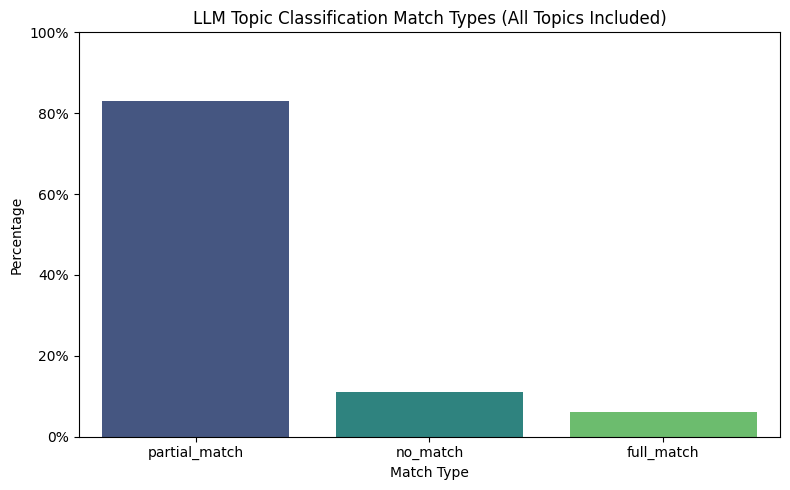


Match Type Breakdown (Excluding other, operational, guidance_forecasts)
      match_type  percentage
0  partial_match    0.833333
1       no_match    0.166667


/tmp/ipykernel_939036/2737207324.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['match_type'] = df_filtered.apply(
/tmp/ipykernel_939036/2737207324.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=match_counts, x='match_type', y='percentage', palette='viridis')


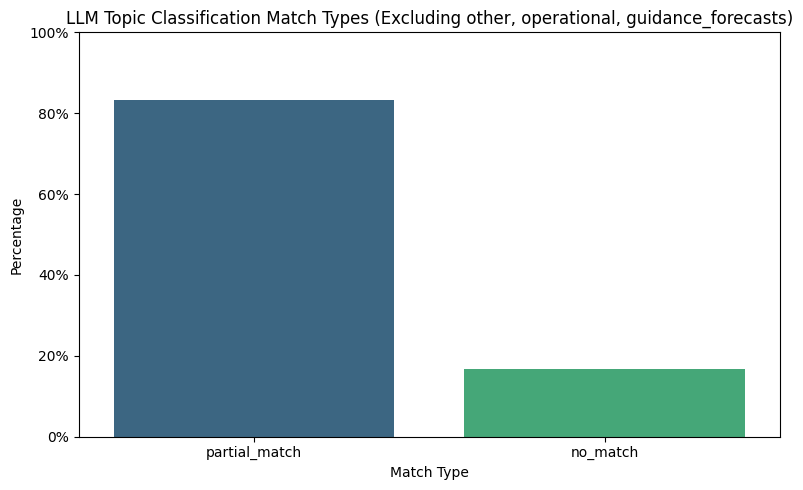

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load labeled data
path = '/scratch/network/mm4846/Thesis Data/other_qna_questions_for_labeling.xlsx'
df = pd.read_excel(path)

# Normalize topic columns
topic_cols = ['llm_topic 1', 'llm_topic 2', 'llm_topic 3', 'true_topic_1', 'true_topic_2']
for col in topic_cols:
    df[col] = df[col].astype(str).str.strip().str.lower()

# Combine LLM topics into a set
df['llm_topics_set'] = df[['llm_topic 1', 'llm_topic 2', 'llm_topic 3']].values.tolist()
df['llm_topics_set'] = df['llm_topics_set'].apply(lambda x: set(t for t in x if t and t != 'nan'))

# Combine true topics into a set
df['true_topics_set'] = df[['true_topic_1', 'true_topic_2']].values.tolist()
df['true_topics_set'] = df['true_topics_set'].apply(lambda x: set(t for t in x if t and t != 'nan'))

# === Function to compute and plot match type stats === #
def compute_and_plot(df_filtered, title_suffix=""):
    # Match classification
    df_filtered['match_type'] = df_filtered.apply(
        lambda row: 'full_match' if row['true_topics_set'] == row['llm_topics_set']
        else 'partial_match' if len(row['true_topics_set'].intersection(row['llm_topics_set'])) > 0
        else 'no_match',
        axis=1
    )

    # Summary stats
    match_counts = df_filtered['match_type'].value_counts(normalize=True).rename_axis('match_type').reset_index(name='percentage')
    print(f"\nMatch Type Breakdown {title_suffix}")
    print(match_counts)

    # Plot
    plt.figure(figsize=(8, 5))
    sns.barplot(data=match_counts, x='match_type', y='percentage', palette='viridis')
    plt.title(f'LLM Topic Classification Match Types {title_suffix}')
    plt.ylabel('Percentage')
    plt.xlabel('Match Type')
    plt.ylim(0, 1)
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
    plt.tight_layout()
    plt.show()

# === Run for full dataset === #
compute_and_plot(df, "(All Topics Included)")

# === Run with exclusions === #
# Define the topics to exclude (adjust this list)
excluded_topics = {'operational', 'other', 'guidance_forecasts'}

# Filter out rows where any of the true topics are in the exclusion list
df_excluded = df[~df['true_topics_set'].apply(lambda x: len(x & excluded_topics) > 0)]

compute_and_plot(df_excluded, f"(Excluding {', '.join(excluded_topics)})")

In [9]:
excluded_topics = {'other', 'operational'}

# Filter out excluded topics **from the topic sets**, not entire rows
df_filtered = df.copy()
df_filtered['llm_topics_set'] = df_filtered['llm_topics_set'].apply(lambda s: set(t for t in s if t not in excluded_topics))
df_filtered['true_topics_set'] = df_filtered['true_topics_set'].apply(lambda s: set(t for t in s if t not in excluded_topics))

df_filtered['llm_coverage'] = df_filtered.apply(llm_to_human_match, axis=1)
llm_labeled = df_filtered[df_filtered['llm_topics_set'].apply(len) > 0]
llm_coverage_rate = llm_labeled['llm_coverage'].mean()
print(f"\n[LLM → Human] If LLM classified it, did human agree? {llm_coverage_rate:.2%} ({llm_coverage_rate:.0%})")

# === Human → LLM ===
df_filtered['human_coverage'] = df_filtered.apply(human_to_llm_match, axis=1)
human_labeled = df_filtered[df_filtered['true_topics_set'].apply(len) > 0]
human_coverage_rate = human_labeled['human_coverage'].mean()
print(f"[Human → LLM] If human labeled it, did LLM catch it? {human_coverage_rate:.2%} ({human_coverage_rate:.0%})")

llm_fp = df_filtered[
    (df_filtered['llm_topics_set'].apply(len) > 0) & (~df_filtered['llm_coverage'])
]

print("\n📌 LLM labeled, but human didn't agree (false positives):")
print(llm_fp[['question', 'llm_topics_set', 'true_topics_set']])

# Human false negatives (human labeled, LLM missed)
human_fn = df_filtered[
    (df_filtered['true_topics_set'].apply(len) > 0) & (~df_filtered['human_coverage'])
]

print("\n📌 Human labeled, but LLM missed it (false negatives):")
print(human_fn[['question', 'llm_topics_set', 'true_topics_set']])

llm_tp = df_filtered[
    (df_filtered['llm_topics_set'].apply(len) > 0) & (df_filtered['llm_coverage'])
]

print("\n✅ LLM labeled, and human agreed (true positives):")
print(llm_tp[['question', 'llm_topics_set', 'true_topics_set']])

# Human true positives — Human labeled and LLM got it right
human_tp = df_filtered[
    (df_filtered['true_topics_set'].apply(len) > 0) & (df_filtered['human_coverage'])
]

print("\n✅ Human labeled, and LLM caught it (true positives):")
print(human_tp[['question', 'llm_topics_set', 'true_topics_set']])



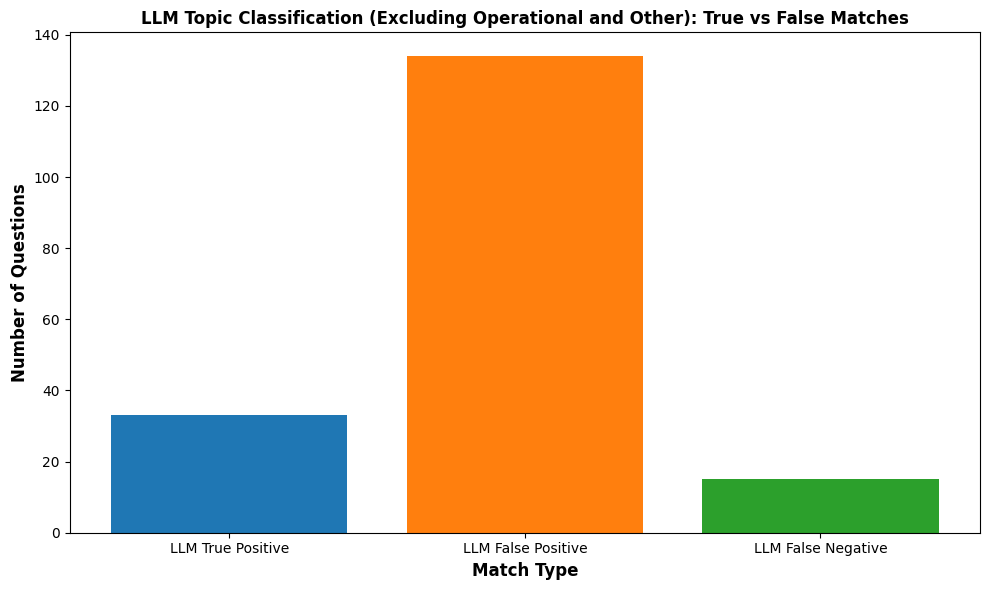

In [15]:
import matplotlib.pyplot as plt

summary_data = {
    'match_type': ['LLM True Positive', 'LLM False Positive', 'LLM False Negative'],
    'count': [
        len(llm_tp),
        len(llm_fp),
        len(human_fn)
    ]
}

df_plot = pd.DataFrame(summary_data)

# Use matplotlib's default color cycle
bar_colors = ['C0', 'C1', 'C2']

plt.figure(figsize=(10, 6))
bars = plt.bar(df_plot['match_type'], df_plot['count'], color=bar_colors)

# Titles and labels (bold)
plt.title('LLM Topic Classification (Excluding Operational and Other): True vs False Matches', fontsize=12, fontweight='bold')
plt.xlabel('Match Type', fontsize=12, fontweight='bold')
plt.ylabel('Number of Questions', fontsize=12, fontweight='bold')

# No rotation on x-tick labels
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()


In [7]:

def llm_to_human_match(row):
    """
    Check if any of the topics labeled by LLM match the human-labeled topics.
    Returns True if overlap, False if no overlap.
    """
    return len(row['llm_topics_set'] & row['true_topics_set']) > 0

def human_to_llm_match(row):
    """
    Check if any of the human-labeled topics are caught by the LLM.
    Returns True if overlap, False if no overlap.
    """
    return len(row['llm_topics_set'] & row['true_topics_set']) > 0

In [9]:
# df_subset = df.iloc[1:100]  # Select the first 10 rows
chunk_size = 5000  # Adjust based on performance
df_list = [df.iloc[i:i + chunk_size] for i in range(0, len(df), chunk_size)]

df_processed = [count_long_questions_without_terms(chunk) for chunk in df_list]
df = pd.concat(df_processed)
# Display the result
# print(df_subset[["other_qna_question_count"]])



In [ ]:
# df
df.to_csv("/scratch/network/mm4846/transcripts_2006_2025_03_18_enhanced_other_qs_v2.csv")

In [ ]:
df_filtered = df[['ticker', 'assigned_quarter', 'other_qna_question_count']]

# df_filtered

master_file_path_2 = "/scratch/network/mm4846/transcripts_2006_2025_03_18_master_v2.csv"

# df_filtered

# master_file_path_2 = "/scratch/network/mm4846/transcripts_2006_2025_03_18_master_v2.csv"
df_v2 = pd.read_csv(master_file_path_2)

# # Merge the single column from df into df_v2
df_merged = df_v2.merge(df_filtered, on=["ticker", "assigned_quarter"], how="left")

# Done! You can now save or inspect the result
# print(df_merged.head())


In [ ]:
df_merged

In [5]:
other_terms = set(
    pol_bigrams +
    share_buyback_bigrams +
    dividend_bigrams +
    climate_terms +
    pandemic_terms +
    outperform_terms +
    supply_chain_terms +
    tariffs_terms +
    inflation_terms +
    capex_terms +
    labor_cost_terms +
    reshoring_terms +
    debt_terms +
    commodity_price_terms +
    geopolitical_terms_2 +
    consumer_demand_terms +
    operational_terms +
    guidance_forecasts_terms +
    rd_terms +
    esg_sustainability_terms +
    cybersecurity_data_protection_terms +
    currency_fluctuations_hedging_terms +
    regulation_terms +
    liquidity_cash_flow_terms +
    tax_strategy_terms +
    ai_terms +
    interest_rate_terms +
    labor_terms
)

In [4]:
# pol_text = [
#     "prescription drug", "cut medicare", "government takeover", "drug plan",
#     "for lowincome", "health care", "human services", "medicare prescription",
#     "have health", "generic drugs", "schip benefits", "like medicaid", 
#     "provide health", "of health", "health insurance",

#     "air act", "from renewable", "climate change", "clean air", "states rights",
#     "greenhouse gas", "nuclear power", "nations energy", "foreign oil", "with opec",
#     "global warming", "energy independence", "legislators are", "emissions from", 
#     "carbon emissions",

#     "estate tax", "tax relief", "bush tax", "the estate", "middleclass tax", 
#     "continued unfair", "full repeal", "typical american", "increase taxes", 
#     "raise taxes", "tax cuts", "largest budget", "repeals the", "tax reform", 
#     "tax cut",

#     "campaign finance", "constitution to", "finance reform", "federal elections", 
#     "appropriations bills", "political system", "constitution and", "public financing", 
#     "of voters", "in politics", "on immigration", "constitution the", 
#     "presidential elections", "federal election", "political parties",

#     "minimum wage", "balanced budget", "legislation provides", "bankruptcy bill", 
#     "medicaid matching", "time congress", "emergency economic", "and discourages", 
#     "surpluses in", "in aid", "create jobs", "government when", 
#     "congress does", "waste by", "government taxes",

#     "free trade", "trade agreement", "trade agreements", "trade barriers", 
#     "freetrade agreement", "up markets", "the andean", "globalization is", 
#     "labor standards", "all trade", "policy objectives", "jordan the", 
#     "american free", "trade relations", "duties on",

#     "street station", "fairness doctrine", "cyber warfare", "on highways", 
#     "faithbased organizations", "human services", "require public", "and faithbased", 
#     "proposals during", "private entities", "the fcc", "structurally deficient", 
#     "hightech jobs", "highspeed rail", "every government",

#     "on terror", "from iraq", "bin laden", "nuclear weapons", "our troops", 
#     "commander in", "in chief", "al qaeda", "weapons of", "mass destruction", 
#     "of military", "in afghanistan", "constitution to", "osama bin", "to authorize"
# ]



pol_bigrams = [
    "the constitution",
    "the states",
    "public opinion",
    "interest groups",
    "of government",
    "the GOP",
    "in Congress",
    "national government",
    "social policy",
    "the civil",
    "elected officials",
    "politics is",
    "political parties",
    "office of",
    "the political",
    "interest group",
    "the bureaucracy",
    "and Senate",
    "government and",
    "for governor",
    "executive branch",
    "support for",
    "the EPA",
    "in government",
    "Congress to",
    "political process",
    "care reform",
    "government in",
    "due process",
    "President Obama",
    "and social",
    "first amendment",
    "Congress the",
    "the Republican",
    "Tea Party",
    "the legislative",
    "of civil",
    "court has",
    "groups and",
    "struck down",
    "shall have",
    "civil war",
    "the Congress",
    "the constitutional",
    "politics and",
    "ruled that",
    "the South",
    "the presidential",
    "government is",
    "of representatives",
    "yes vote",
    "policy goals",
    "to enact",
    "African Americans",
    "economic policy",
    "proposed by",
    "of social",
    "a political",
    "of speech",
    "federal bureaucracy",
    "civil service",
    "and party",
    "government policy",
    "federal courts",
    "state the",
    "argued that",
    "executive privilege",
    "the democratic",
    "of politics",
    "islamic state",
    "president has",
    "national security",
    "the candidates",
]


share_buyback_bigrams = [
    "share buyback",
    "stock repurchase",
    "repurchase authorization",
    "buyback program",
    "repurchase plan",
    "authorized repurchase",
    "stock buyback",
    "shareholder return",
    "buyback activity",
    "repurchase activity",
    "capital return",
    "buyback announcement",
    "share repurchase",
    "repurchase initiative",
    "repurchase schedule",
    "buyback",
    "repurchase",
    "repo",
    "share repo",
]



dividend_bigrams = [
    "dividend",
    "dividend payout",
    "dividend increase",
    "payout ratio",
    "dividend yield",
    "quarterly dividend",
    "annual dividend",
    "special dividend",
    "dividend declaration",
    "dividend growth",
    "dividend payment",
    "cash dividend",
    "dividend policy",
    "declared dividend",
    "dividend distribution",
    "dividend reinvestment"
]





climate_terms = [
    "air pollution", "electric vehicle", "new energy",
    "air quality", "energy climate", "ozone layer",
    "air temperature", "energy conversion", "renewable energy",
    "biomass energy", "energy efficient", "sea level",
    "carbon dioxide", "energy environment", "sea water",
    "carbon emission", "environmental sustainability", "snow ice",
    "carbon energy", "extreme weather", "solar energy",
    "carbon neutral", "flue gas", "solar thermal",
    "carbon price", "forest land", "sustainable energy",
    "carbon sink", "gas emission", "water resource",
    "carbon tax", "ghg emission", "water resources",
    "clean air", "global decarbonization", "wave energy",
    "clean energy", "global warm", "weather climate",
    "clean water", "greenhouse gas", "wind energy",
    "climate change", "heat power", "wind power",
    "coastal area", "Kyoto protocol", "wind resource",
    "coastal region", "natural hazard",
    "greenhouse gas", "gas emission", "carbon tax", "emission trade", "carbon reduction",
    "reduce emission", "air pollution", "carbon price", "dioxide emission", "carbon market",
    "carbon emission", "reduce carbon", "environmental standard", "epa regulation", "mercury emission",
    "carbon dioxide", "energy regulatory", "nox emission", "energy independence",
    "coastal area", "forest land", "storm water", "natural hazard", "water discharge",
    "global warm", "sea level", "heavy snow", "sea water", "ice product",
    "snow ice", "nickel metal", "air water", "warm climate"
]

pandemic_terms = [
    "sarscov",
    "coronavirus",
    "corona virus",
    "ncov",
    "covid",
    "hn", 
    "swine flu",
    "ahn",
    "sars",
    "merscov",
    "severe acute respiratory syndrome",
    "middle east respiratory syndrome",
    "mers",
    "ebola",
    "zika"
]

outperform_terms = [
"beat expectations",
    "outpeformed",
    "outperform",
    "outperforming",
"exceeded guidance",
"outperformed peers",
"strong growth",
"record quarter",     
    "record sales",
"surpassed estimates", 
    "beat estimates",
"margin expansion"
"strong momentum",
"improved performance",
"strong quarter"
]


supply_chain_terms = [
"supply disruptions", 
"logistics delays",
"material shortages",
"shipping constraints",
"inventory bottlenecks",
"freight challenges",
"supplier delays",   
"distribution issues",
"procurement challenges",  
"supply chain constraints", 
"supply chain", 
]

tariffs_terms = [
    "tariff",
    "tariffs",
    "tariff impact",
    "tariff increases",
    "import duties",
    "import duty",
    "trade barriers",
    "trade war",
    "retaliatory tariffs",
    "customs duty",
    "protectionism",
    "import taxes",
    "levies",
    "section 301",
    "section 232",
#     "exemptions",
    "tariff relief",
    "anti-dumping",
    "countervailing duty",
    "trade disputes",
    "border tax",
#     "compliance cost",
    "export restrictions",
    "duty drawback",
    "import penalties",
    "import penalty",
    "import tax"    
]


inflation_terms = [
    "inflation",
    "inflationary pressure",
    "inflationary environment",
    "inflation outlook",
    "price increases",
    "pricing pressure",
    "cost escalation",
    "cost inflation",
    "input cost",
    "commodity prices",
    "commodity inflation",
    "energy inflation",
    "wage inflation",
    "labor costs",
    "raw material costs",
    "pricing actions",
    "pricing power",
#     "margin compression",
    "cost pass-through",
#     "interest rates",
    "monetary tightening",
    "headline inflation",
    "core inflation",
    "CPI reading",
    "producer prices",
#     "macroeconomic headwinds",
#     "economic pressure",
    "purchasing power",
#     "demand elasticity",
    "cost environment"
]


capex_terms = [
    "capital expenditure",
    "capital expenditures",
    "capex",
    "capital spending",
    "investment in capacity",
    "plant expansion",
    "equipment upgrade",
    "capital allocation",
    "maintenance capital",
    "capital projects",
    "expansion plans",
    "capital budget",
    "infrastructure investment",
]


labor_cost_terms = [
    "labor costs",
    "wage pressure",
    "wage inflation",
    "workforce expenses",
    "employee benefits",
    "labor negotiations",
    "union contracts",
    "payroll costs",
    "talent shortage",
    "staffing challenges",
    "overtime expenses",
    "minimum wage",
]


reshoring_terms = [
    "reshoring",
    "onshoring",
    "nearshoring",
    "domestic production",
    "local manufacturing",
    "supply chain relocation",
    "manufacturing footprint",
    "domestic supply base",
    "production shift",
    "localized operations",
    "plant repatriation",
]



debt_terms = [
    "debt",
    "leverage",
    "bond issuance",
    "credit facility",
    "interest expense",
    "loan covenants",
    "refinancing",
    "debt maturity",
    "capital structure",
    "liquidity position",
    "net debt",
    "balance sheet",
    "leverage ratio",
    "debt repayment",
    "interest coverage",
]

commodity_price_terms = [
    "commodity prices",
    "raw material costs",
    "input costs",
    "steel prices",
    "oil price",
    "energy costs",
    "agricultural commodities",
    "metal prices",
    "commodity hedge",
    "commodity volatility",
    "spot price",
    "commodity futures",
]

geopolitical_terms_2 = [
    "geopolitical",
    "war",
    "military conflict",
    "sanctions",
    "country risk",
    "political unrest",
    "security issues",
    "embargo",
    "diplomatic tensions",
    "international relations",
    "expropriation",
    "terrorism",
]

consumer_demand_terms = [
    "consumer demand",
    "consumer spending",
    "customer orders",
    "purchasing behavior",
    "demand outlook",
    "sales momentum",
    "foot traffic",
    "customer sentiment",
    "end-market demand",
    "buying patterns",
    "consumer trends",
    "order backlog",
]


operational_terms = [
    # Core operational phrases
    "operational efficiency",
    "operational improvement",
    "operational excellence",
    "operational metrics",
    "operating performance",
    "operational synergies",
    "process optimization",
    "throughput",
    "production capacity",
    "capacity utilization",
    "asset utilization",
    "downtime",
    "maintenance shutdown",
    "operational risk",
    "workflow efficiency",
    "standard operating procedures",
    "cycle time",
    "lead time",
    "yield improvement",
    "quality control",
    "quality assurance",

    # Cost & margin management
    "cost structure",
    "cost optimization",
    "cost discipline",
    "cost savings program",
    "cost-cutting initiatives",
    "overhead reduction",
    "fixed cost",
    "variable cost",
    "operating expenses",
    "operating leverage",
    "OPEX",
    "SG&A",
    "margin expansion",
    "margin compression",
    "gross margin",
    "operating margin",
    "EBIT margin",
    "cost escalation",

    # Revenue & profit
    "top-line growth",
    "bottom-line results",
    "operating income",
    "operating profit",
    "EBIT",
    "EBITDA",
    "net income",
    "profitability metrics",
    "profit margin",
    "revenue growth",
    "sales revenue",
    "income statement highlights",

    # Production & capacity
    "production ramp-up",
    "production volume",
    "production efficiency",
    "capacity expansion",
    "facility utilization",
    "bottleneck reduction",
    "line capacity",
    "scaling operations",
    "manufacturing throughput",
    "plant expansion",
    "factory optimization",
    "assembly line efficiency",

    # Supply & inventory
    "inventory management",
    "inventory turnover",
    "inventory optimization",
    "stock levels",
    "lead-time reduction",
    "logistics efficiency",
    "distribution network",
    "warehousing strategy",
    "fulfillment capacity",

    # Workforce & organization
    "labor productivity",
    "workforce efficiency",
    "headcount reduction",
    "staffing optimization",
    "shift scheduling",
    "talent allocation",
    "organizational restructuring",
    "resource utilization",

    # Continuous improvement methods
    "lean manufacturing",
    "lean processes",
    "six sigma",
    "continuous improvement",
    "Kaizen",
    "best practices",
    "process reengineering",
    "productivity gains",
    "efficiency ratio",

    # Synergies & integration (especially post-M&A)
    "synergy realization",
    "synergy capture",
    "integration plan",
    "cost synergies",
    "operational integration",
    "merger integration milestones",

    # General operational commentary
    "operational highlights",
    "operational focus",
    "business continuity",
    "operational resiliency",
    "day-to-day operations",
    "operational challenges",
    "operational outlook",
    "execution risk",
    "scalability",
    "throughput constraints",
]




guidance_forecasts_terms = [
    "earnings guidance",
    "revenue outlook",
    "EPS outlook",
    "growth projections",
    "guidance range",
    "visibility into next quarter",
    "full-year expectations",
    "long-term targets",
    "quarterly guidance",
    "revenue expectations",
    "guidance assumptions",
    "guidance revision",
    "margin guidance",
    "guidance"
]

rd_terms = [
    "earnings guidance",
    "R&D",
    "revenue outlook",
    "EPS outlook",
    "growth projections",
    "guidance range",
    "visibility into next quarter",
    "full-year expectations",
    "long-term targets",
    "quarterly guidance",
    "revenue expectations",
    "guidance assumptions",
    "guidance revision",
    "margin guidance",
    "R&D spending",
    "innovation pipeline",
    "technology investments",
    "new product development",
    "innovation pipeline",
    "technology investments",
    "development timeline",
    "R&D expense",
    "commercialization strategy",
    "clinical trials",
    "new product development",
    "innovation pipeline",
    "technology roadmap",
    "development timeline",
    "R&D intensity",
    "research partnerships",
    "patent filings"
]

esg_sustainability_terms = [
    "emissions reduction",
    "net-zero targets",
    "carbon footprint",
    "renewable energy",
    "sustainability initiatives",
    "diversity & inclusion",
    "ESG reporting",
    "corporate social responsibility",
    "diversity targets",
    "social responsibility",
    "environmental impact",
    "governance practices",
    "diversity goals",
    "sustainability metrics",
    "corporate governance",
    "climate commitments",
    "ESG disclosures",
    "community engagement",
    "green investments",
    "climate risk",
    "social responsibility"
]

cybersecurity_data_protection_terms = [
    "cybersecurity",
    "data protection",
    "cyber attack",
    "data privacy",
    "cyber risk",
    "security investments",
    "breach prevention",
    "IT security",
    "ransomware",
    "data privacy",
    "cyber risk",
    "security investments",
    "breach prevention",
    "IT security",
    "ransomware",
    "incident response",
    "cybersecurity spending",
    "vulnerability assessment",
    "security protocols",
    "data governance",
    "regulatory compliance",
    "cyber threat landscape",
    "network security",
    "cloud security",
    "threat detection",
    "system resilience",
    "endpoint protection",
    "GDPR compliance",
    "CCPA compliance",
    "data breach",
    "privacy regulations",
    "security breach"
]

currency_fluctuations_hedging_terms = [
    "foreign exchange",
    "currency fluctuations",
    "currency hedging",
    "FX hedging",
    "currency exposure",
    "foreign exchange risk",
    "FX volatility",
    "hedging strategies",
    "FX movements",
    "exchange rate impact",
    "currency headwinds",
    "translation risk",
    "FX hedging",
    "currency fluctuations",
    "foreign revenue exposure",
    "hedging instruments",
    "currency translation effects",
    "hedge contracts",
    "currency impacts",
    "FX exposure"
]

regulation_terms = [
    "regulation", "regulatory", "compliance", "oversight", "governance", "enforcement",
     "mandate", "rulemaking", "statutory", "reform", "policy",
    "legal requirements", "regulatory landscape", "restrictions", "standards",
    "approval process", "compliance costs", "licensing", "monitoring",
    "impact of regulations", "evolving regulations", "regulatory hurdles", "government oversight",
    "audits", "reporting requirements", "regulatory challenges", "shifting regulatory environment",
    "industry standards", "regulatory burden", "penalties", "litigation risk", "policy changes",
    "new legislation", "legal exposure", "regulatory headwinds", "transparency requirements", 
    "regulatory scrutiny", "adapting to regulations", "compliance initiatives",
    "heightened oversight", "agency directives", "ongoing discussions with regulators",
    "evolving compliance landscape", "uncertainty in regulations", "regulatory clarity"
]

liquidity_cash_flow_terms = [
    "liquidity",
    "cash flow",
    "free cash flow",
    "cash generation",
    "working capital",
    "capital allocation",
    "cash balance",
    "liquidity position",
    "operating cash flow",
    "cash utilization",
    "cash deployment",
    "cash management",
    "free cash flow",
    "cash reserves",
    "cash burn rate",
    "funding needs",
    "cash generation",
    "working capital management",
    "cash cycle",
    "financing activities",
    "debt maturities"
]


tax_strategy_terms = [
    "tax strategy",
    "tax rate",
    "effective tax rate",
    "tax planning",
    "tax expense",
    "tax reform",
    "tax implications",
    "tax rate",
    "corporate tax",
    "tax policy",
    "tax benefits",
    "tax credits",
    "tax legislation",
    "tax liabilities",
    "deferred tax",
    "tax guidance",
    "tax savings",
    "international taxation",
    "tax efficiency",
    "tax optimization",
    "tax exposure",
    "transfer pricing",
    "tax incentives",
    "tax treatment",
    "tax burden",
    "tax provisions",
    "effective tax rate",
    "tax compliance",
    "tax audit",
    "tax strategy",
    "tax regime",
    "tax position",
    "tax expense",
    "tax avoidance",
    "tax risk",
    "global tax",
    "tax jurisdictions",
    "tax disputes",
    "tax management",
    "tax structure",
    "effective rate",
    "statutory rate",
    "repatriation",
    "transfer pricing",
    "offshore earnings",
    "cash repatriation",
    "foreign earnings",
    "earnings overseas",
    "jurisdictional mix",
    "offshore cash",
    "offshore profits",
]


ai_terms = [
    "artificial intelligence", "machine learning", "deep learning", "neural networks",
    "large language model", "generative AI", "automation", "computer vision", "natural language processing",
    "chatbot", "predictive analytics", "AI-driven", "AI-powered", "autonomous systems", "algorithmic trading",
    "robotics", "reinforcement learning", "AI research", "supervised learning", "unsupervised learning",
    "AI adoption", "AI infrastructure", "AI applications", "transformer models", "big data analytics",
    "data science", "speech recognition", "AI ethics", "AI regulation", "computational intelligence",
    "automated decision-making", "deep neural networks", "AI integration", "AI investment",
    "AI capabilities", "AI-powered solutions", "LLM deployment", "machine learning models",
    "AI efficiency", "AI-enhanced operations", "intelligent automation", "AI-driven insights",
    "AI cost savings", "AI monetization"
]

interest_rate_terms = [
    "interest rate", "federal funds rate", "monetary policy", "central bank", "rate hike",
    "rate cut", "yield curve", "bond yields", "credit market", "fixed income", "rate environment",
    "interest rate risk", "rate-sensitive sectors", "benchmark rate", "rate forecast", "inflation targeting",
    "real interest rates", "discount rate", "repo rate", "policy rate", "long-term rates",
    "short-term rates", "rate impact", "macroprudential policy", "sovereign debt yields", "credit spreads",
    "rate expectations", "interest rate swap", "economic tightening", "quantitative easing",
    "liquidity injections", "rate volatility", "neutral rate", "financial conditions index",
    "debt servicing costs", "cost of capital", "interest rate headwinds", "interest expense",
    "refinancing risk", "rate uncertainty", "borrowing costs", "debt markets"
]

labor_terms = [
    "labor market", "employment rate", "unemployment", "job creation", "labor force participation",
    "wage growth", "workforce development", "labor shortage", "job market", "labor unions",
    "gig economy", "minimum wage", "workforce training", "skilled labor", "blue-collar workers",
    "white-collar employment", "hiring trends", "job openings", "wage pressure", "employment trends",
    "remote work", "workforce retention", "labor mobility", "contract workers", "full-time employment",
    "part-time employment", "staffing shortages", "union negotiations", "strike activity",
    "labor disputes", "worker productivity", "job security", "employee benefits", "wage inflation",
    "labor cost management", "recruitment challenges", "hiring freeze", "layoffs",
    "employee turnover", "labor cost headwinds", "unionized workforce", "workforce flexibility"
]








